In [1]:
import operator, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Seed for reproducibility
np.random.seed(42)

# Generate synthetic data from a symbolic function with some noise
# True function: y = 2 * sin(x) + 0.5 * x^2
x = np.linspace(-5, 5, 200)

y_true = 2 * np.sin(x) + x**2
noise = np.random.normal(0, 0.5, size=x.shape)
y_noisy = y_true + noise

# Create DataFrame
df = pd.DataFrame({"x": x, "y": y_noisy, "y_true": y_true})

In [3]:
# --- 1. Define primitive functions ---
FUNCTIONS = {
    "add": (operator.add, 2),
    "sub": (operator.sub, 2),
    "mul": (operator.mul, 2),
    "div": (lambda a,b: a/b if b != 0 else 1, 2),
    "sin": (math.sin, 1),
    "cos": (math.cos, 1)
}
TERMINALS = ["x"]

In [4]:
def generate_random_expr(depth=3, seed=None):
    if not seed is None:
        np.random.seed(seed)
    if depth == 0 or (depth < 3 and random.random() < 0.3):
        if random.random() < 0.5:
            return "x"
        else:
            return random.uniform(-3, 3)
    func, (op, arity) = random.choice(list(FUNCTIONS.items()))
    return (func,) + tuple(generate_random_expr(depth-1) for _ in range(arity))

In [5]:
# --- 3. Evaluate expression tree ---
def eval_expr(expr, x):
    if isinstance(expr, str):
        return x
    elif isinstance(expr, (int, float)):
        return expr
    else:
        func, *args = expr
        return FUNCTIONS[func][0](*[eval_expr(arg, x) for arg in args])

In [6]:
# --- 4. Fitness ---
def fitness(expr, xs, ys):
    preds = np.array([eval_expr(expr, x) for x in xs])
    return np.mean((preds - ys)**2)

In [7]:
# --- 5. Mutation (replace random subtree) ---
def mutate(expr, depth=3):
    if isinstance(expr, (str, float, int)) or random.random() < 0.2:
        return generate_random_expr(depth)
    func, *args = expr
    return (func,) + tuple(mutate(arg, depth-1) for arg in args)

In [8]:
# --- 6. Evolution loop ---
def evolve(xs, ys, generations=50, pop_size=50):
    population = [generate_random_expr() for _ in range(pop_size)]
    for gen in range(generations):
        scored = [(fitness(expr, xs, ys), expr) for expr in population]
        scored.sort(key=lambda t: t[0])
        best = scored[0]
        #print(f"Gen {gen} best fitness={best[0]:.4f} expr={best[1]}")
        # Selection: keep top 10, mutate to refill
        survivors = [expr for (_, expr) in scored[:10]]
        population = survivors + [mutate(random.choice(survivors)) for _ in range(pop_size-10)]
    return best

In [9]:
# --- Example use ---
np.random.seed(42)
random.seed(42)

# Generate synthetic data from a symbolic function with some noise
# True function: y = 2 * sin(x) + 0.5 * x^2
x = np.linspace(-5, 5, 200)
y_true = 2 * np.sin(x) + x**2
noise = np.random.normal(0, 0.5, size=x.shape)
y_noisy = y_true + noise

best_fit = evolve(x, y_noisy, generations=100, pop_size=50)
best_model = best_fit[1]
print("Best found:", best_model)

Best found: ('add', ('mul', 'x', 'x'), ('sin', 'x'))


In [10]:
# --- Estimated values with symbolic regression model

y_est = [eval_expr(best_model, xi) for xi in x]

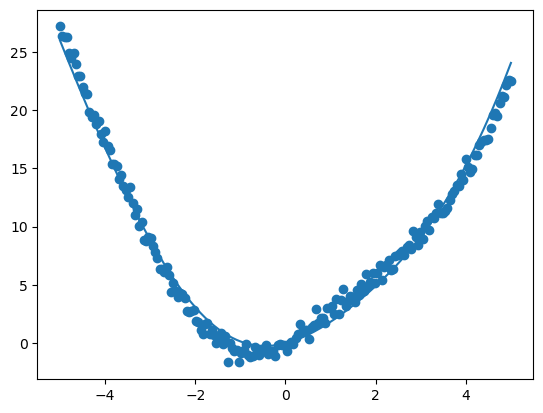

In [11]:
plt.plot(x, y_est)
plt.scatter(x, y_noisy)

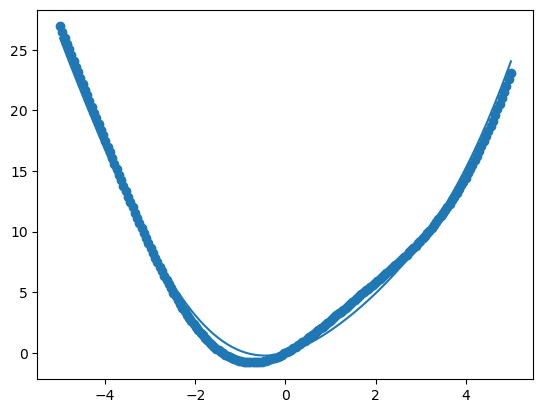

In [12]:
plt.plot(x, y_est)
plt.scatter(x, y_true)